# Problem Statement:
    Based on people's book suggestions on Reddit (r/booksuggestions), what are similar books that other people have read/suggested? Using NLP and Deep Learning methods, let's analyze those posts and build a recommender system.

## Project Overview
1. Pull data from Reddit posts (r/booksuggestions) between July 25, 2010 and March 30, 2021
2. Use adv. NLP methods to analyze data:
   - clean the posts, remove special characters
   - detect entities on each row
   - use cont. skip-grams from Word2Vec for similar words
   - create a function that input a post and returns 3 books
3. Conclusion and recommendations.


### Goals of this notebook
    - Exploratore the data 
    - Identify entities 
    - Model and build the recommender system 
    - Conclusion & Recommendation

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import re

import spacy #https://scapy.readthedocs.io/en/latest/installation.html#installing-scapy-v2-x
from spacy import displacy
from collections import Counter
import en_core_web_sm

import gensim 
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from pprint import pprint
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk, conlltags2tree, tree2conlltags
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## EDA & Identifying Entities

Let's first import our data into a Pandas dataframe

In [3]:
# checking directory
# os.listdir(path='/Users/ronald_asseko_messa/Google Drive/dsir-125-large-files/')

# reading the data file
booksuggestions_clean_df = pd.read_pickle('/Users/ronald_asseko_messa/Google Drive/dsir-125-large-files/booksuggestions_clean_df.pkl')

# here is our data frame
df = booksuggestions_clean_df[['clean_text']]
df.head()

,clean_text
0,Looking for Horror fiction that explores the u...
1,Books that are about or talk about US Army PSY...
2,Looking for new sci-fiSo I read a ton of sci-f...
3,Recommend me my very first book to readBeing h...
4,Started a book club. Suggestions?Somehow I bec...


Next, we create vectors of words (tokens) for each post, root words (lemmatize) for each token, and identify entities with pos_tag from NLTK. The lemmatizer removes the suffixes or prefixes used with a word while the pos_tag is used to understand sentence structures. For instance, a word like "churches" and returns "church." and detects books on each row.

In [14]:
# tokenize words
# changed token to be run on raw text and cleanner version
# since some special characters are used in names, titles ... 
# this version works best 

df['text_tokens'] = df['clean_text'].apply(lambda x: word_tokenize(str(x)))
df.head()

# # lemmatize clean text
lemma = WordNetLemmatizer() # instantiate lemmatizer

def word_lemmatizer(text):
    lem_text = [lemma.lemmatize(i) for i in text]
    return lem_text

df['text_tokens_lemma'] = df['text_tokens'].apply(lambda x: word_lemmatizer(x))

df.head()

# tag each token with its entity
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

df['tokens_pos_tagged'] = df['text_tokens'].apply(lambda x: word_pos_tagger(x))
df.head()

,clean_text,text_tokens,text_tokens_lemma,tokens_pos_tagged
0,Looking for Horror fiction that explores the u...,"[Looking, for, Horror, fiction, that, explores...","[Looking, for, Horror, fiction, that, explores...","[(Looking, VBG), (for, IN), (Horror, NNP), (fi..."
1,Books that are about or talk about US Army PSY...,"[Books, that, are, about, or, talk, about, US,...","[Books, that, are, about, or, talk, about, US,...","[(Books, NNS), (that, WDT), (are, VBP), (about..."
2,Looking for new sci-fiSo I read a ton of sci-f...,"[Looking, for, new, sci-fiSo, I, read, a, ton,...","[Looking, for, new, sci-fiSo, I, read, a, ton,...","[(Looking, VBG), (for, IN), (new, JJ), (sci-fi..."
3,Recommend me my very first book to readBeing h...,"[Recommend, me, my, very, first, book, to, rea...","[Recommend, me, my, very, first, book, to, rea...","[(Recommend, VB), (me, PRP), (my, PRP$), (very..."
4,Started a book club. Suggestions?Somehow I bec...,"[Started, a, book, club, ., Suggestions, ?, So...","[Started, a, book, club, ., Suggestions, ?, So...","[(Started, VBD), (a, DT), (book, NN), (club, N..."


Let's use the spaCy English model to identify entities on one post.

In [5]:
# load nlp english model to analyze entities 
nlp = spacy.load("en_core_web_sm") # nlp = en_core_web_sm.load()

# call entity on first row
[(x.text, x.label_) for x in nlp(df['clean_text'][3]).ents]

[('first', 'ORDINAL'),
 ('This summer', 'DATE'),
 ('Harry Potter', 'PERSON'),
 ('Rome', 'GPE')]

A sample of our text (the first million characters) to count the number of entities, and look at their unique value counts. Note that our NLP model is capped at 1M characters, anything beyond that won't work. (as of April 2021)

In [8]:
# as an example, let's pull the number of:
# entities, their unique labels, and most common ones

text = '. '.join(df['clean_text'].astype(str))
article = nlp(text[:1_000_000]) # nlp limit is 1_000_000 characters
print('number of entities:',len(article.ents))

labels = [x.label_ for x in article.ents]
print('\n unique labels: \n',Counter(labels))

# uncomment this section to see the most common ones
# items = [x.text for x in article.ents]
# print('\n most common words: ',Counter(items).most_common(5))

number of entities: 7195

 unique labels: 
 Counter({'PERSON': 2173, 'ORG': 1374, 'DATE': 787, 'CARDINAL': 723, 'GPE': 554, 'WORK_OF_ART': 507, 'NORP': 328, 'ORDINAL': 254, 'LOC': 92, 'EVENT': 90, 'PRODUCT': 74, 'TIME': 64, 'LANGUAGE': 61, 'FAC': 58, 'MONEY': 22, 'PERCENT': 12, 'LAW': 11, 'QUANTITY': 11})


We have 7195 entities, among which 507 books in our first 1M characters, while 462 when using raw text and 343 with clean text. Punctuations, special characters, and numeric values add more books to our list. Let's just take a look at few sentences with a raw mark-up of entities.

In [10]:
# Selecting one sentence as an example
sentences = [x for x in article.sents]

# lets now see the raw markup for the sentence above

# uncomment the two lines below to change the markup colors 
# colors = {"WORK_OF_ART": "#fc9ce7"}
# options = {"ents": ["WORK_OF_ART"], "colors": {"#fc9ce7"}}

displacy.render(nlp(str(sentences[20:25])), jupyter=True, style='ent')

From our NLP model, Harry Potter was identified as a Person (People, including fictional). We can see how that entity can fall into another category like book (WORK_OF_ART), which tells us that we should pay attention to misclassifications.

In [7]:
# uncomment to visualize the entire article 
# visualizing the entire article
# displacy.render(article, jupyter=True, style='ent')

# uncomment to see the list of each word with its entity name
# dict([(str(x), x.label_) for x in article.ents])

    Entities with corresponding description:

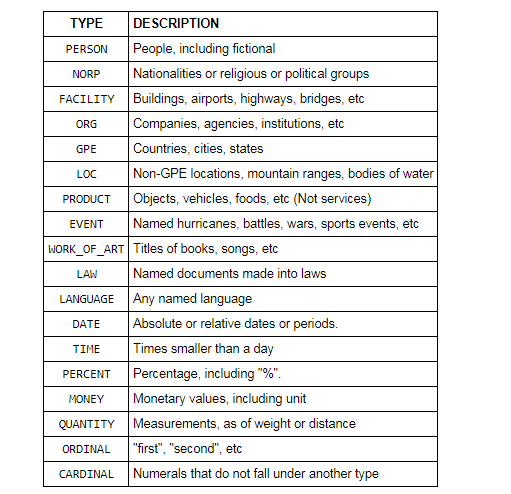

Here is the dependency of one sentence from above. I use displaCy, a visualizer from spaCy that uses JavaScript, SVG, and CSS to show us how computers understand human language.

In [11]:
# display the dependency for the above sentence
displacy.render(nlp(str(sentences[20])), 
                style='dep', jupyter = True, options = {'distance': 120})


From the sample of 1M characters we've used to analyze our text, here is the list of the top 10 books.

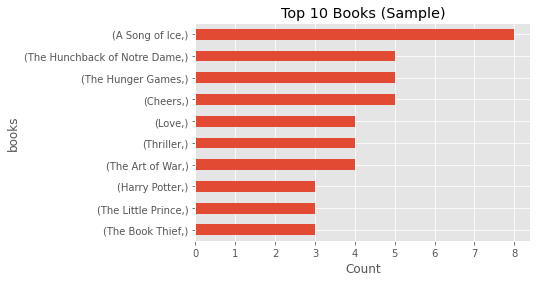

In [12]:
# plotting the list of books into a data frame

books_sample_1 =  pd.DataFrame([str(x) for x in article.ents if x.label_ in ('WORK_OF_ART')])
books_sample_1.rename(columns = {0: 'book_list'}, inplace=True)
books_sample_1.value_counts(
    ascending=False)[:10].plot(kind='barh').invert_yaxis()
plt.ylabel('books')
plt.xlabel('Count')
plt.title('Top 10 Books (Sample)');

Books tend to have the pattern of being in a title format (every first letter is an upper case), which spaCy handles well. One extension of this work will be to set up an entity detection based on such a pattern to see if there is any improvement. Next, we go back to our main data to retrieve books from each row.

In [17]:
# detect books from each row
def detect_books(text):
    books = [str(x) for x in nlp(str(text)).ents if x.label_ in ('WORK_OF_ART')]
    return books

df['books_detected'] = df['clean_text'].apply(lambda x: detect_books(x))
df.head()

,clean_text,text_tokens,text_tokens_lemma,tokens_pos_tagged,books_detected
0,Looking for Horror fiction that explores the u...,"[Looking, for, Horror, fiction, that, explores...","[Looking, for, Horror, fiction, that, explores...","[(Looking, VBG), (for, IN), (Horror, NNP), (fi...",[]
1,Books that are about or talk about US Army PSY...,"[Books, that, are, about, or, talk, about, US,...","[Books, that, are, about, or, talk, about, US,...","[(Books, NNS), (that, WDT), (are, VBP), (about...",[]
2,Looking for new sci-fiSo I read a ton of sci-f...,"[Looking, for, new, sci-fiSo, I, read, a, ton,...","[Looking, for, new, sci-fiSo, I, read, a, ton,...","[(Looking, VBG), (for, IN), (new, JJ), (sci-fi...",[]
3,Recommend me my very first book to readBeing h...,"[Recommend, me, my, very, first, book, to, rea...","[Recommend, me, my, very, first, book, to, rea...","[(Recommend, VB), (me, PRP), (my, PRP$), (very...",[]
4,Started a book club. Suggestions?Somehow I bec...,"[Started, a, book, club, ., Suggestions, ?, So...","[Started, a, book, club, ., Suggestions, ?, So...","[(Started, VBD), (a, DT), (book, NN), (club, N...",[]


Once we have all the books, we can put them into a data frame and see their frequencies

In [18]:
# put all the books into a df
books = pd.DataFrame([str(x[0]) for x in df['books_detected'] if len(x) > 0], columns=['book_list'])

# books
books

,book_list
0,The Art of War
1,Seinfeldia
2,The Pickwick Papers
3,Terminator
4,How the West was Won
...,...
14018,Catcher in the Rye
14019,"Stars, Looking"
14020,Sleigh
14021,The Hunger Games


The model detected 14,023 books (864 more than using the raw text, and 3,041 more than a general cleaning method - for a total of 13,159, and 10,982 respectively). Here are our 10 most popular books.

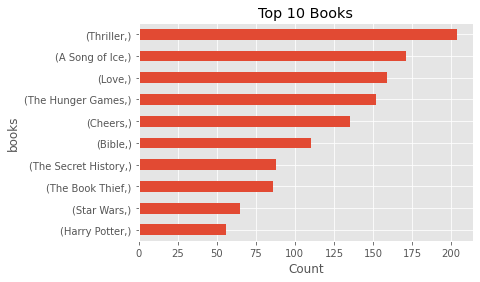

In [19]:
# Top 10 of the most popular books
books.value_counts(ascending=False)[:10].plot(kind='barh').invert_yaxis()
plt.ylabel('books')
plt.xlabel('Count')
plt.title('Top 10 Books');

## Modeling

Once we have identified all the books on each row, we can start modeling. We use the Continuous Skip-gram model from Word2Vec (W2V), a two-layer neural network that:

    - Takes a vector of words as an input.
    - Generates the surrounding "context words" as the output.

In [573]:
# # Train the model! 
corpus = df['text_tokens']

print('instantiate w2v...')
model = Word2Vec(corpus,      # Corpus of data.
                 size=100,    # How many dimensions do you want in your word vector?
                 window=5,    # How many "context words" do you want?
                 min_count=1, # Ignores words below this threshold.
                 sg=1,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
                 workers=4)   # Number of "worker threads" to use (parallelizes process).
print('Done')

instantiate w2v...
Done


Uncomment this part to check our vocabulary.

In [15]:
# uncomment to check the vocabulary of our model
# model.wv.vocab

Let's now use "Bible" as our first example.

In [574]:
# Example of the most similar words
[model.wv.most_similar('Bible')]

[[('Quran', 0.7612322568893433),
  ('Poisonwood', 0.7593402862548828),
  ('Descartes', 0.7567734718322754),
  ('Sisyphus', 0.7411362528800964),
  ('Gulag', 0.7182480096817017),
  ('Bhagavad', 0.715805172920227),
  ('Enlightenment', 0.7142306566238403),
  ('Stoic', 0.7136459350585938),
  ('Economist', 0.7125303745269775),
  ('Socrates', 0.7098446488380432)]]

We were able to retrieve similar words with their corresponding cosine similarity scores. Scores range from 0 to 1 and measure the angle between vectors (in this case, words within each sentence). The smaller the angle, the more similar the words, the higher the cosine similarity score.
Although most of these words are books, they can also be from other entities like people, locations, organizations, etc. Quran is our most simmilar word with a cosine similarity score of 0.76. Poisonwood, which is from the novel "The Poisonwood Bible" by Barbara Kingsolver, follows with 0.76. Our next step is to take a post without any books, input that into a function that we'd define, and filter the output to return only books.

In [592]:
# Lets check out this post
print(df['clean_text'][0])

Looking for Horror fiction that explores the uncanny (Lovecraftian?)I love horror films that delve into the outer reaches of human perception, and present monsters or concepts that avoid the usual cliche of the "tormented spirit" or the "psycho killer". I haven't read any Lovecraft, but I believe his brand of horror is the kind of thing I'm looking for. Any recommendations would be much appreciated.


In [621]:
# define a function that takes in words
# and return the top three books, with the corresponding posts 
# based on cosine similarity

def post_to_book(word, num_books):
    print('tokenizing...')
    tokens = word_tokenize(str(word))
    result = []
    print('computing the cosine similarity...')
    for row in df['text_tokens']:
        result.append(model.wv.n_similarity(tokens, row))
    
    result = pd.DataFrame(result, columns=['similarity_scores'])
    result['similar_text'] = df['clean_text']
    result['similar_tokens'] = df['text_tokens']
    result['list_of_books'] = df['books_detected']
    print('filtering books...')
    result.list_of_books = result.list_of_books.apply(lambda x: np.nan if len(x)==0 else x)
    result_books = result.loc[result['list_of_books'].notna(), :
                             ].sort_values('similarity_scores', ascending=False)[:num_books]
    print('\n top 3 books with scores:')
    print(result_books[['list_of_books', 'similarity_scores']])
    print('\n here is the corresponding data frame...')
    return result_books

### Results

In [622]:
# using the above text to return the top 3 books
post_to_book(df['clean_text'][0], 3)

tokenizing...
computing the cosine similarity...
filtering books...

 top 3 books with scores:
             list_of_books  similarity_scores
5497   [the Twilight Zone]           0.989369
68435         [The Ritual]           0.988831
64473              [Teeth]           0.988466

 here is the corresponding data frame...


,similarity_scores,similar_text,similar_tokens,list_of_books
5497,0.989369,Any suggestions of some books written before 1...,"[Any, suggestions, of, some, books, written, b...",[the Twilight Zone]
68435,0.988831,books about fictional cults? ; ; Hi there! Rea...,"[books, about, fictional, cults, ?, Hi, there,...",[The Ritual]
64473,0.988466,"Books like the movie ""Jennifer's Body""I've bee...","[Books, like, the, movie, ``, Jennifer, 's, Bo...",[Teeth]


### Conclusion / Suggestions

    The model is indeed able to return 3 books based on our word2vec model and using the cosine similarity. The sentence above, "Looking for Horror fiction..." returned "The Twilight Zone", "The Ritual", and "Teeth" with more than 0.989369 for each.

    Next: 
        - Use the lemmatize words as a base for the vocabulary
        - Use the tag from NLTK to create a pattern that will be used for our entity detection.. 
        - Do more cleaning
        - Use different models like BERT to identify entities